In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from tqdm import tqdm
import zipfile

import dgl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv, EdgeConv, NNConv,SAGEConv
from torch.nn import Linear, Sequential, ReLU
import torch_geometric.transforms as T
from torch.optim import Adam
from torch.utils.data import Dataset
import numpy as np
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score

from torch.cuda import is_available
device = 'cpu'
if is_available():
	device = 'gpu'
print(device)

from torch_geometric.explain import GNNExplainer, ExplainerConfig, ModelConfig
from typing import Optional, List
import matplotlib.pyplot as plt
import pandas as pd



cpu


# LOADING DATA

In [37]:
# In order to run the code put the dataset called archive.zip into the folder. I can't send it because otherwise the zip file become to heavy
zip_file_path = "archive.zip"

extracted_dir = "dataset" 

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
    
extracted_files = os.listdir(extracted_dir)
print("Extracted files:", extracted_files)

Extracted files: ['PS_20174392719_1491204439457_log.csv']


In [3]:
file_path = 'dataset/PS_20174392719_1491204439457_log.csv'
df = pd.read_csv(file_path)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# DATA ANALYSIS

In [4]:
# Check for missing values
print(df.isnull().sum())

columns_to_drop = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned.head()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0,0
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0,0
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0,0


In [5]:
fraud_count_by_type = df_cleaned.groupby('type')['isFraud'].sum()
print(fraud_count_by_type)

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


In [6]:
fraudulent_types = ['CASH_OUT', 'TRANSFER']
df_cleaned = df_cleaned[df_cleaned['type'].isin(fraudulent_types)]
df_cleaned.head()

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0
15,1,CASH_OUT,229133.94,C905080434,C476402209,0,0
19,1,TRANSFER,215310.30,C1670993182,C1100439041,0,0
24,1,TRANSFER,311685.89,C1984094095,C932583850,0,0


In [7]:
type_mapping = {'TRANSFER': 0, 'CASH_OUT': 1}
# Replace values in the 'type' column
df_cleaned['type'] = df['type'].replace(type_mapping)
df_cleaned.head()

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud
2,1,0,181.00,C1305486145,C553264065,1,0
3,1,1,181.00,C840083671,C38997010,1,0
15,1,1,229133.94,C905080434,C476402209,0,0
19,1,0,215310.30,C1670993182,C1100439041,0,0
24,1,0,311685.89,C1984094095,C932583850,0,0



Class Distribution:
Number of fraudulent transactions: 8213
Number of non-fraudulent transactions: 2762196


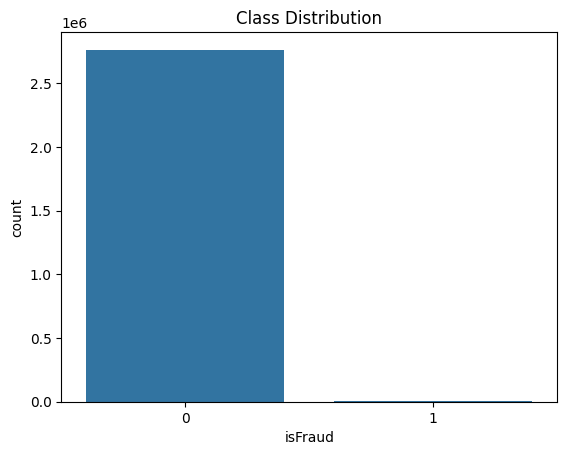

Numerical values of amounts:
             count          mean           std   min          25%        50%  \
isFraud                                                                        
0        2762196.0  3.141155e+05  8.771441e+05  0.01   82908.2325  171034.46   
1           8213.0  1.467967e+06  2.404253e+06  0.00  127091.3300  441423.44   

                 75%         95%          max  
isFraud                                        
0         305994.185   942414.68  92445516.64  
1        1517771.480  8006429.04  10000000.00  


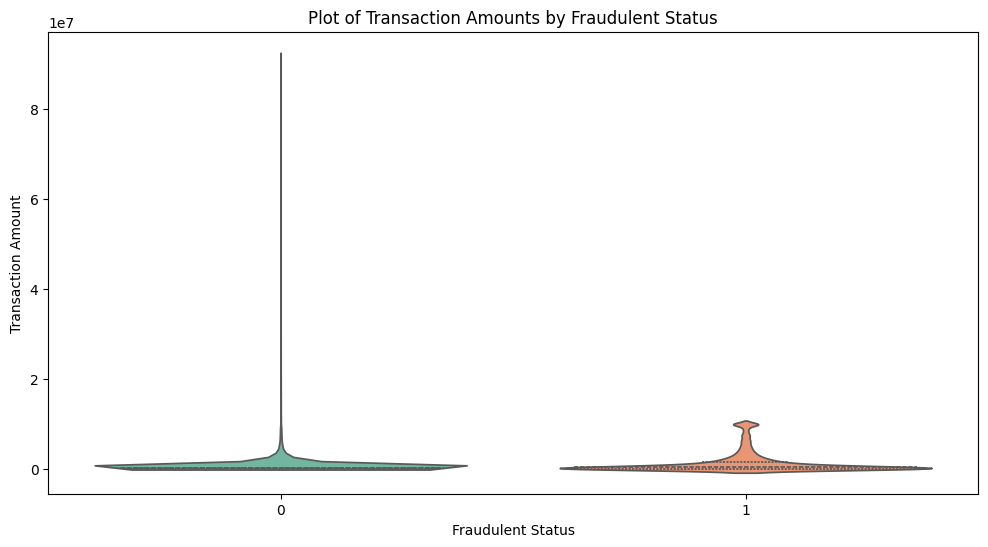

Numerical values for Distribution of Transaction Types :
   type  isFraud    Count
0     0        0   528812
1     0        1     4097
2     1        0  2233384
3     1        1     4116
-----------------------------------
0 - 0 = TRANSFER - NOT Fraudolent
0 - 1 = TRANSFER - Fraudolent
1 - 0 = CASH_OUT - NOT Fraudolent
1 - 1 = CASH_OUT - Fraudolent


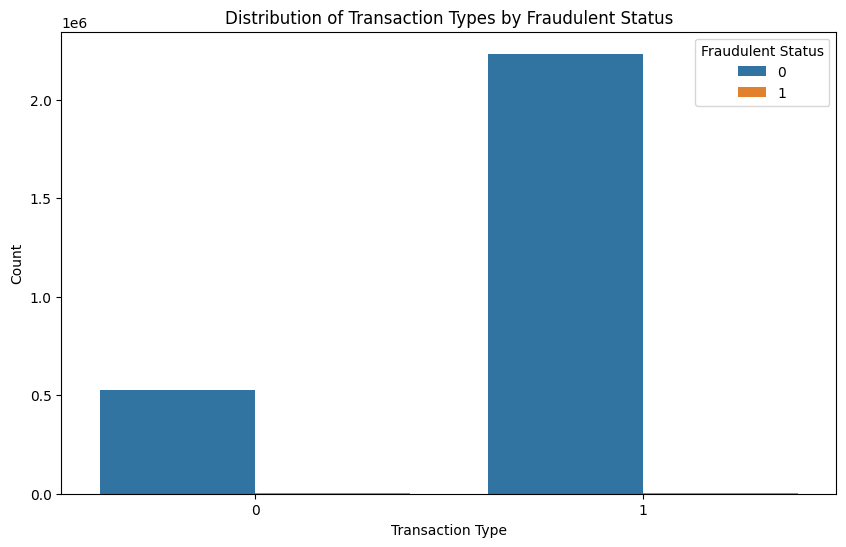

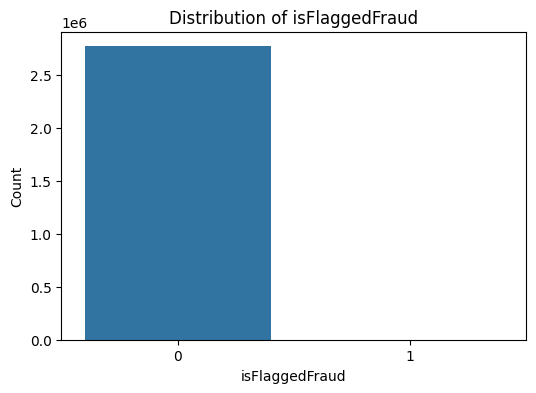

Numerical values for Distribution of isFlaggedFraud:
   isFlaggedFraud    Count
0               0  2770393
1               1       16


In [8]:
# Check for class distribution in the 'isFraud' column
fraud_counts = df_cleaned['isFraud'].value_counts()
print(f"\nClass Distribution:\nNumber of fraudulent transactions: {fraud_counts[1]}\nNumber of non-fraudulent transactions: {fraud_counts[0]}")
sns.countplot(x='isFraud', data=df_cleaned)
plt.title('Class Distribution')
plt.show()

boxplot_stats = df_cleaned.groupby('isFraud')['amount'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])
print("Numerical values of amounts:")
print(boxplot_stats)

plt.figure(figsize=(12, 6))
sns.violinplot(x='isFraud', y='amount', data=df_cleaned, inner='quartile', hue='isFraud', palette='Set2', legend=False)
plt.title('Plot of Transaction Amounts by Fraudulent Status')
plt.xlabel('Fraudulent Status')
plt.ylabel('Transaction Amount')
plt.show()

# Display numerical values for the countplot (TRANSFER)
countplot_stats_transfer = df_cleaned.groupby(['type', 'isFraud']).size().reset_index(name='Count')
print("Numerical values for Distribution of Transaction Types :")
print(countplot_stats_transfer)
print("-----------------------------------")
print("0 - 0 = TRANSFER - NOT Fraudolent")
print("0 - 1 = TRANSFER - Fraudolent")
print("1 - 0 = CASH_OUT - NOT Fraudolent")
print("1 - 1 = CASH_OUT - Fraudolent")

# Distribution of Transaction Types (TRANSFER)
plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='isFraud', data=df_cleaned)
plt.title('Distribution of Transaction Types by Fraudulent Status')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend(title='Fraudulent Status')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='isFlaggedFraud', data=df_cleaned)
plt.title('Distribution of isFlaggedFraud')
plt.xlabel('isFlaggedFraud')
plt.ylabel('Count')
plt.show()

# Display numerical values for the countplot (isFlaggedFraud)
countplot_stats_flagged = df_cleaned['isFlaggedFraud'].value_counts().reset_index(name='Count')
print("Numerical values for Distribution of isFlaggedFraud:")
print(countplot_stats_flagged)

In [9]:
name_mapping = {}
idx = 0

for col in ['nameOrig', 'nameDest']:
    for name in df_cleaned[col]:
        if name not in name_mapping:
            name_mapping[name] = idx
            idx += 1

df_cleaned['nameOrig_idx'] = df_cleaned['nameOrig'].map(name_mapping)
df_cleaned['nameDest_idx'] = df_cleaned['nameDest'].map(name_mapping)

# Create a matrix with unique names and their indices
name_matrix = [[name, idx] for name, idx in name_mapping.items()]

print("DataFrame with indices:")
print(df_cleaned[['step', 'type', 'amount', 'nameOrig_idx', 'nameDest_idx', 'isFraud']])

print("\nMatrix with unique names and indices:")
print(name_matrix[:10])

DataFrame with indices:
         step type      amount  nameOrig_idx  nameDest_idx  isFraud
2           1    0      181.00             0       2768630        1
3           1    1      181.00             1       2768631        1
15          1    1   229133.94             2       2768632        0
19          1    0   215310.30             3       2768633        0
24          1    0   311685.89             4       2768634        0
...       ...  ...         ...           ...           ...      ...
6362615   743    1   339682.13       2768625       3277506        1
6362616   743    0  6311409.28       2768626       3277507        1
6362617   743    1  6311409.28       2768627       2973166        1
6362618   743    0   850002.52       2768628       3277508        1
6362619   743    1   850002.52       2768629       2821175        1

[2770409 rows x 6 columns]

Matrix with unique names and indices:
[['C1305486145', 0], ['C840083671', 1], ['C905080434', 2], ['C1670993182', 3], ['C1984094095'

# GRAPH CREATION

In [10]:
# Generate the graph
G = nx.DiGraph()

# Add nodes for originators 
G.add_nodes_from(df_cleaned['nameOrig_idx'], type='Customer')
G.add_nodes_from(df_cleaned['nameDest_idx'], type='Customer')

# Add edges for transactions
edges = []
for _, row in tqdm(df_cleaned.iterrows(), total=len(df_cleaned), desc="Adding Edges"):
    edges.append((row['nameOrig_idx'], row['nameDest_idx'], {'amount': row['amount'], 'transaction_type': row['type'],'step': row['step']}))

G.add_edges_from(edges)

Adding Edges: 100%|██████████| 2770409/2770409 [03:02<00:00, 15165.48it/s]


Adding Edges: 100%|██████████| 409/409 [00:00<00:00, 9531.29it/s]


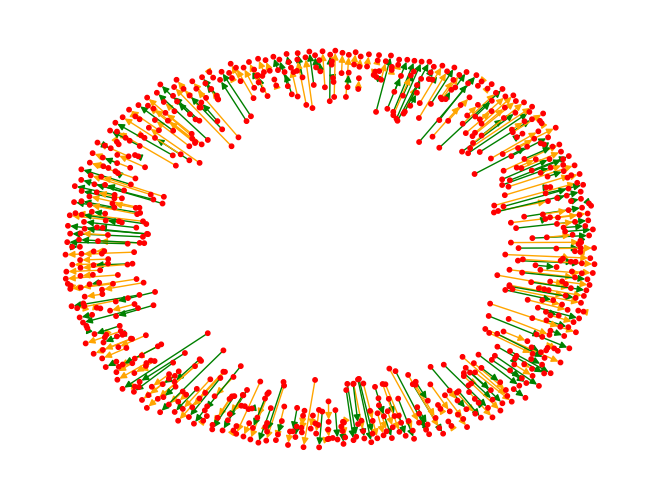

In [49]:
# Visualize Graph by doing a mega sample form the df and the apply the function above
df_cleaned_test=df_cleaned.copy()
df_cleaned_test = df_cleaned_test.drop(df_cleaned_test.index[:2770000])
df_cleaned_test

G_test = nx.DiGraph()

# Add nodes for originators
G_test.add_nodes_from(df_cleaned_test['nameOrig_idx'], type='Customer')
G_test.add_nodes_from(df_cleaned_test['nameDest_idx'], type='Customer')

# Add edges for transactions
edges = []
for _, row in tqdm(df_cleaned_test.iterrows(), total=len(df_cleaned_test), desc="Adding Edges"):
    edges.append((row['nameOrig_idx'], row['nameDest_idx'], {'amount': row['amount'], 'transaction_type': row['type'],'step': row['step']}))

G_test.add_edges_from(edges)

pos = nx.spring_layout(G_test)

node_color_map = {'Customer': 'red'}

# Define a color map for transaction types (0 or 1)
edge_color_map = {0: 'green', 1: 'orange'}
# Node colors based on type (Customer or Transaction)
node_colors = [node_color_map[node_type] for node_type in nx.get_node_attributes(G_test, 'type').values()]

# Edge colors based on transaction type
edge_colors = [edge_color_map[edge_type] for edge_type in nx.get_edge_attributes(G_test, 'transaction_type').values()]

node_sizes = [10 * G_test.degree(node) for node in G_test.nodes()]
nx.draw(G_test, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors)
plt.show()

In [47]:
# In order to run this code make sure to run the code of the Graph generation
# Save the graphs
nx.write_graphml(G, "financial_transactions_graph.graphml")
#G = nx.read_graphml("financial_transactions_graph.graphml")
print(G.number_of_nodes())
print(G.number_of_edges())

In [11]:
#   Create the Masks
np.random.seed(42)

train_probability = 0.8
val_probability = 0.2

#train_mask = np.random.rand(len(df_cleaned)) < train_probability
train_mask = np.zeros(len(df_cleaned))
train_mask[:int(train_probability * len(df_cleaned))] = 1
df_cleaned['train_mask'] = train_mask.astype(int)
train_mask_list = df_cleaned['train_mask'].tolist()

test_mask = []

for i in tqdm(range(len(train_mask_list)), desc="Creating val_mask"):
    if train_mask_list[i] == 1:
        test_mask.append(0)
    else:
        test_mask.append(1)

test_mask = np.array(test_mask)
df_cleaned['test_mask'] = test_mask.astype(int)
df_cleaned.head()

Creating val_mask: 100%|██████████| 2770409/2770409 [00:00<00:00, 2887444.61it/s]


,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,nameOrig_idx,nameDest_idx,train_mask,test_mask
2,1,0,181.00,C1305486145,C553264065,1,0,0,2768630,1,0
3,1,1,181.00,C840083671,C38997010,1,0,1,2768631,1,0
15,1,1,229133.94,C905080434,C476402209,0,0,2,2768632,1,0
19,1,0,215310.30,C1670993182,C1100439041,0,0,3,2768633,1,0
24,1,0,311685.89,C1984094095,C932583850,0,0,4,2768634,1,0


# DATA STRUCTURE INIZIALIZATION

In [12]:
sample_nodes = list(G.nodes())

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')
x=[]
# Print the properties of the sample nodes
for node in sample_nodes:
    #print(f"Node: {node}, Properties: {node_properties[node]}")
    x.append([node])
x=torch.tensor(x, dtype=torch.float)

In [13]:
sample_size = 5
sample_edges= list(G.edges())
sample= list(G.edges())[:10]
print(sample)
print("TRANSFER: 0, CASH_OUT: 1")
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

[(0, 2768630), (1, 2768631), (2, 2768632), (3, 2768633), (4, 2768634), (5, 2768635), (6, 2768636), (7, 2768637), (8, 2768638), (9, 2768639)]
TRANSFER: 0, CASH_OUT: 1
{'amount': 181.0, 'transaction_type': 0, 'step': 1}
{'amount': 181.0, 'transaction_type': 1, 'step': 1}
{'amount': 229133.94, 'transaction_type': 1, 'step': 1}
{'amount': 215310.3, 'transaction_type': 0, 'step': 1}
{'amount': 311685.89, 'transaction_type': 0, 'step': 1}


In [14]:
# Create the Data Structure

label = torch.tensor(df_cleaned['isFraud'].values, dtype=torch.float)
train_mask = torch.tensor(df_cleaned['train_mask'].values, dtype=torch.bool)
test_mask = torch.tensor(df_cleaned['test_mask'].values, dtype=torch.bool)
m=[]
for i in sample_edges:
    l=[]
    l.append(i[0])
    l.append(i[1])
    m.append(l)
edge_index = torch.tensor(m, dtype=torch.long)
numeric_columns = ['step', 'amount', 'type']
df_cleaned[numeric_columns] = df_cleaned[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values
df_cleaned = df_cleaned.dropna()

edge_attributes = torch.tensor(df_cleaned[numeric_columns].values, dtype=torch.float).t()
data = Data(edge_attr=edge_attributes, edge_index=edge_index.t().contiguous(), y=label , x=x, train_mask=train_mask, test_mask=test_mask)
data

Data(x=[3277509, 1], edge_index=[2, 2770409], edge_attr=[3, 2770409], y=[2770409], train_mask=[2770409], test_mask=[2770409])

# MLP MODEL

In [35]:
class MLP(nn.Module):
	def __init__(self, dataset):
		super().__init__()
		self.dataset = dataset

		self.layers = nn.Sequential(
			nn.Linear(3, 64),
			nn.ReLU(),
			nn.Linear(64,32),
            nn.ReLU(),
			nn.Linear(32,2)
		)
	
	def forward(self, data):
		x = data.edge_attr.t() 
		output = self.layers(x)
		return output 
	
model = MLP(data)

def eval_edge_classifier(model, graph, mask):
	model.eval()

	pred = model(graph).argmax(dim=1)
	correct	= (pred[mask] == graph.y[mask]).sum()
	acc = correct/mask.sum()
		
	return acc

def train_edge_classifier(model, graph, optimizer, criterion, n_epochs):
    best_acc = 0.0
    best_loss = 10000
    train_loss_curve = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()

        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask].long())

        train_loss_curve.append(loss.item())

        loss.backward()
        optimizer.step()

        acc = eval_edge_classifier(model, graph, graph.test_mask)

        if epoch % 2 == 0:
            print(f'Epoch {epoch}, Train loss {loss:.3f} Test acc {acc:.3f}')

        # Save the model if it has the best test accuracy
        if acc >= best_acc and loss < best_loss:
            best_acc = acc
            best_loss = loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f'Saved the best model with test accuracy: {best_acc:.3f}')

    return model, train_loss_curve



In [36]:
lr = 0.01
wd = 5e-4
n_epochs = 100
num_edge_features = data.edge_attr.shape[0]
mlp = MLP(num_edge_features).to(device)
mlp.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [64]:
optimizer_mlp = Adam(mlp.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()
mlp, train_loss_curve = train_edge_classifier(mlp, data, optimizer_mlp, criterion, n_epochs)

test_acc = eval_edge_classifier(mlp, data, data.test_mask)
print(f'Test accuracy {test_acc:.3f}')

Saved the best model with test accuracy: 0.003
Epoch 2, Train loss 43115.383 Test acc 0.007
Epoch 4, Train loss 389.052 Test acc 0.997
Epoch 6, Train loss 908.289 Test acc 0.997
Epoch 8, Train loss 1161.309 Test acc 0.997
Epoch 10, Train loss 1275.286 Test acc 0.997
Epoch 12, Train loss 1244.688 Test acc 0.997
Epoch 14, Train loss 1034.460 Test acc 0.997
Epoch 16, Train loss 619.147 Test acc 0.997
Epoch 18, Train loss 1868.178 Test acc 0.997
Epoch 20, Train loss 776.097 Test acc 0.997
Epoch 22, Train loss 1422.352 Test acc 0.997
Epoch 24, Train loss 1933.122 Test acc 0.997
Epoch 26, Train loss 2320.280 Test acc 0.997
Epoch 28, Train loss 2589.736 Test acc 0.997
Epoch 30, Train loss 2735.496 Test acc 0.997
Epoch 32, Train loss 2732.536 Test acc 0.997
Epoch 34, Train loss 2559.403 Test acc 0.997
Epoch 36, Train loss 2191.371 Test acc 0.997
Epoch 38, Train loss 1610.103 Test acc 0.996
Epoch 40, Train loss 798.174 Test acc 0.992
Epoch 42, Train loss 19784.334 Test acc 0.992
Epoch 44, Train

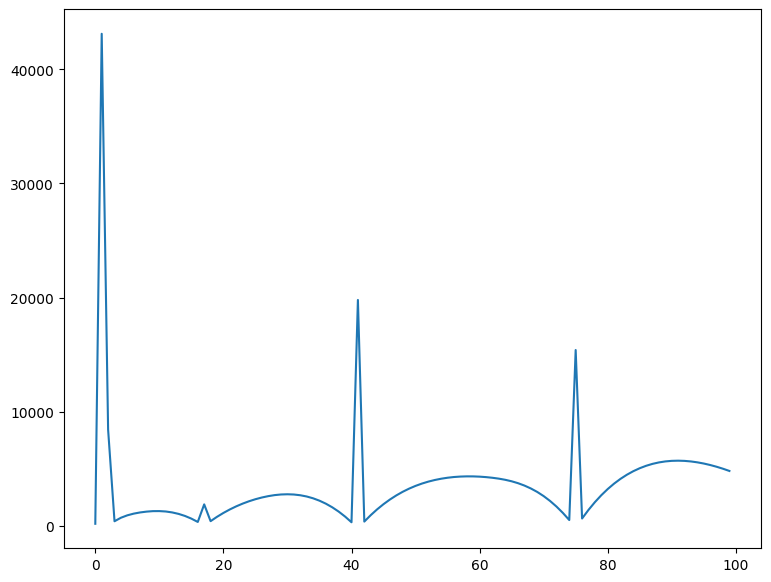

In [65]:
plt.figure(figsize=(9,7))
plt.plot(range(n_epochs), train_loss_curve)

# GCN MODEL

In [15]:
def eval_edge_classifier_gcn(model, graph):
    model.eval()
    graph.to(device)

    targets = []
    preds = []
    # Forward pass
    with torch.no_grad():
        output = model(graph.x, graph.edge_index, graph.edge_attr).view(-1).sigmoid()

    pred = (output > 0.5).int()
    targets.extend(graph.y)
    preds.extend(pred.cpu().detach().numpy())

    accuracy = accuracy_score(graph.y, pred)
    f1 = f1_score(graph.y, pred)

    return accuracy, f1

def train_edge_classifier_gcn(model, graph, optimizer, criterion, n_epochs):
    best_acc = 0.0
    best_loss = 10000
    train_loss_curve = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph.x, graph.edge_index, graph.edge_attr)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask].float())

        train_loss_curve.append(loss.item())

        loss.backward()
        optimizer.step()

        acc, f1 = eval_edge_classifier_gcn(model, graph)
        if epoch % 2 == 0:
            print(f'Epoch {epoch}, Train loss {loss:.3f} Test acc {acc:.3f} F1 score {f1:.3f}')

        # Save the model if it has the best test accuracy
        if acc >= best_acc and loss < best_loss:
            best_acc = acc
            best_loss = loss
            torch.save(model.state_dict(), "best_model_gcn.pth")
            print(f'Saved the best model with test accuracy: {best_acc:.3f} and loss: {best_loss:.3f}')

    return model, train_loss_curve


In [16]:
class GCN(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension, out_dimension, linear_input_dimension):
        super().__init__()
        self.conv1 = GCNConv(input_dimension, hidden_dimension)
        self.conv2 = GCNConv(hidden_dimension, out_dimension)
        self.classifier1 = torch.nn.Linear(linear_input_dimension, 32)
        self.classifier2 = torch.nn.Linear(32, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x
    
    def decode(self, z, edge_index, edge_attr):
        z = torch.cat([z[edge_index[0]], edge_attr.t(), z[edge_index[1]]], dim=1)
        z = self.classifier1(z).relu()
        z  = self.classifier2(z)
        return z.view(-1)

    def forward(self, x, edge_index, edge_attr):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_index, edge_attr)

n_epochs=50
input_dim = 1
hidden_dim = 128
output_dim = 2
linear_input_dim=7
lr = 0.01
wd = 5e-4


In [17]:
gcn = GCN(input_dim, hidden_dim, output_dim, linear_input_dim).to(device)

gcn.load_state_dict(torch.load('best_model_gcn.pth'))

<All keys matched successfully>

In [61]:
optimizer_gcn = Adam(gcn.parameters(), lr=lr, weight_decay=wd)
criterion = nn.BCEWithLogitsLoss()
gcn, train_lss_curve_gcn = train_edge_classifier_gcn(gcn, data, optimizer_gcn, criterion, n_epochs)

test_acc , f1= eval_edge_classifier_gcn(gcn, data)
print(f'Test accuracy {test_acc:.3f} and F1 {f1:.3f}')

Epoch 2, Train loss 2366.962 Test acc 0.995 F1 score 0.048
Saved the best model with test accuracy: 0.995 and loss: 2366.962
Saved the best model with test accuracy: 0.997 and loss: 719.242
Epoch 4, Train loss 678.356 Test acc 0.997 F1 score 0.000
Saved the best model with test accuracy: 0.997 and loss: 678.356
Epoch 6, Train loss 1037.569 Test acc 0.997 F1 score 0.000
Epoch 8, Train loss 1225.047 Test acc 0.997 F1 score 0.000
Epoch 10, Train loss 1271.892 Test acc 0.997 F1 score 0.000
Epoch 12, Train loss 1200.190 Test acc 0.997 F1 score 0.000
Epoch 14, Train loss 1032.526 Test acc 0.997 F1 score 0.000
Epoch 16, Train loss 786.562 Test acc 0.993 F1 score 0.005
Epoch 18, Train loss 723.471 Test acc 0.946 F1 score 0.011
Epoch 20, Train loss 526.441 Test acc 0.995 F1 score 0.003
Epoch 22, Train loss 503.668 Test acc 0.997 F1 score 0.000
Epoch 24, Train loss 431.377 Test acc 0.997 F1 score 0.000
Epoch 26, Train loss 281.334 Test acc 0.950 F1 score 0.015
Epoch 28, Train loss 179.900 Test a

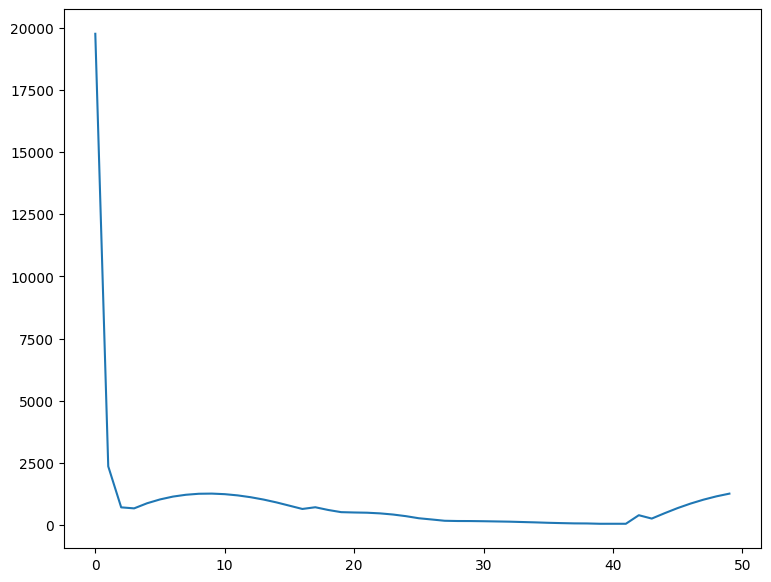

In [62]:
plt.figure(figsize=(9,7))
plt.plot(range(n_epochs), train_lss_curve_gcn)

In [17]:
test_acc , f1= eval_edge_classifier_gcn(gcn, data)
print(f'Test accuracy {test_acc:.3f} and F1 {f1:.3f}')

Test accuracy 0.997 and F1 0.000


# EXPLAINABILITY

In [18]:
unmasked_pred = gcn(data.x, data.edge_index, data.edge_attr)
node_idx      = 500
pred_node_idx = unmasked_pred[node_idx]
pred_node_idx

tensor(-14711.0654, grad_fn=<SelectBackward0>)

In [19]:

label = torch.tensor(df_cleaned['isFraud'].values, dtype=torch.long)
explanation_type = 'model'
node_mask_type = 'attributes'

mode = "multiclass_classification"
task_level = 'edge'

model_config = ModelConfig(mode=mode, task_level=task_level, return_type="probs")
explainer_config = ExplainerConfig(explanation_type, node_mask_type=node_mask_type)

explainer = GNNExplainer(
    model=gcn,
    nodes=[node_idx],
    edge_mask_type='object',
    edge_mask_smooth=0.01,
)

# Connect the explainer to an explainer configuration and a model configuration
explainer.connect(explainer_config, model_config)

# Generate explanation for the specified node
explanation = explainer(gcn, data.x, data.edge_index, target=label, edge_attr=data.edge_attr)

# Access the node and edge masks
node_mask = explanation.node_mask
#edge_mask = explanation.edge_mask

print(node_mask)
#print(edge_mask)

tensor([[0.0000],
        [0.2743],
        [0.0000],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])


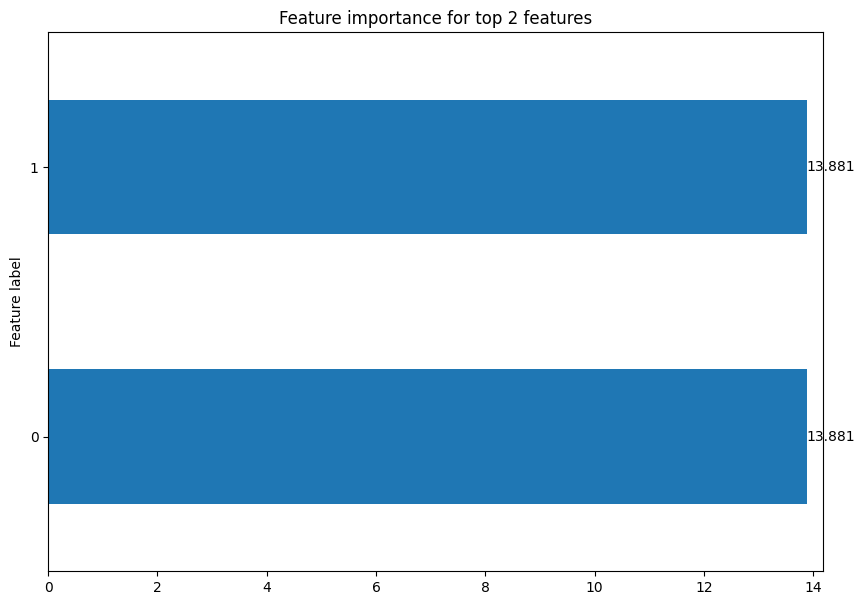

In [31]:
def _visualize_score(
    score: torch.Tensor,
    labels: List[str],
    path: Optional[str] = None,
    top_k: Optional[int] = None,
):


    #if len(labels) != score.numel():
        #raise ValueError(f"The number of labels (got {len(labels)}) must "
                        #f"match the number of scores (got {score.numel()})")

    score = score.cpu().numpy()
    df = pd.DataFrame({'score': score}, index=labels)
    df = df.sort_values('score', ascending=False)
    df = df.round(decimals=3)


    if top_k is not None:
        df = df.head(top_k)
        title = f"Feature importance for top {len(df)} features"
    else:
        title = f"Feature importance for {len(df)} features"
    ax = df.plot(
        kind='barh',
        figsize=(10, 7),
        title=title,
        ylabel='Feature label',
        xlim=[0, float(df['score'].max()) + 0.3],
        legend=False,
    )
    plt.gca().invert_yaxis()
    ax.bar_label(container=ax.containers[0], label_type='edge')
    if path is not None:
        plt.savefig(path)
    else:
        plt.show()

    plt.close()
    
def visualize_feature_importance(
        explanation,
        path: Optional[str] = None,
        feat_labels: Optional[List[str]] = None,
        top_k: Optional[int] = None,
    ):
        r"""Creates a bar plot of the node feature importances by summing up
        the node mask across all nodes.

        Args:
            path (str, optional): The path to where the plot is saved.
                If set to :obj:`None`, will visualize the plot on-the-fly.
                (default: :obj:`None`)
            feat_labels (List[str], optional): The labels of features.
                (default :obj:`None`)
            top_k (int, optional): Top k features to plot. If :obj:`None`
                plots all features. (default: :obj:`None`)
        """
        node_mask = explanation.get('node_mask')
        if node_mask is None:
            raise ValueError(f"The attribute 'node_mask' is not available "
                             f"in '{explanation.__class__.__name__}' "
                             f"(got {explanation.available_explanations})")

        if feat_labels is None:
            feat_labels = range(node_mask.size(1))

        score = node_mask.sum(dim=0)

        return _visualize_score(score, feat_labels, path, top_k)



visualize_feature_importance(explanation, feat_labels=df_cleaned['isFraud'], top_k=2)

# EDGE MODEL

In [57]:
def eval_edge_classifier_gat(model, graph):
    model.eval()
    graph.to(device)
    
    # Initialize lists for targets and predictions
    targets = []
    preds = []
    # Forward pass
    with torch.no_grad():
        output = model(graph).view(-1).sigmoid()

    pred = (output > 0.5).int()
    targets.extend(graph.y)
    preds.extend(pred.cpu().detach().numpy())

    accuracy = accuracy_score(graph.y, pred)
    f1 = f1_score(graph.y, pred)

    return accuracy, f1

def train_edge_classifier_gat(model, graph, optimizer, criterion, n_epochs):
    best_acc = 0.0
    best_loss = 10000
    train_loss_curve = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        print(out)
        print(graph.y)
        print(out.shape)
        print(graph.y.shape)
        loss = criterion(out, graph.y)

        train_loss_curve.append(loss.item())

        loss.backward()
        optimizer.step()

        acc, f1 = eval_edge_classifier_gat(model, graph)
        if epoch % 2 == 0:
            print(f'Epoch {epoch}, Train loss {loss:.3f} Test acc {acc:.3f} F1 score {f1:.3f}')

        # Save the model if it has the best test accuracy
        if acc >= best_acc and loss < best_loss:
            best_acc = acc
            best_loss = loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f'Saved the best model with test accuracy: {best_acc:.3f} and loss: {best_loss:.3f}')

    return model, train_loss_curve


In [138]:
class EdgeModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EdgeModel, self).__init__()
        self.nn_conv = NNConv(in_channels=input_dim, out_channels=output_dim, nn=Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, output_dim)))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Ensure edge_attr has the correct shape
        edge_attr = edge_attr.view(-1, edge_attr.size(1), 1)

        # Apply NNConv
        x = self.nn_conv(x, edge_index, edge_attr)
        x = torch.sigmoid(x)

        return x
         

In [139]:
gat1 = EdgeModel(1, 32 , 1).to(device)

In [140]:
lr= 0.01
wd=5e-4
n_epochs=20
optimizer_gat = Adam(gat1.parameters(), lr=lr, weight_decay=wd)
criterion = nn.BCEWithLogitsLoss()
gat, train_lss_curve_gcn = train_edge_classifier_gat(gat1, data, optimizer_gat, criterion, n_epochs)

test_acc , f1= eval_edge_classifier_gat(gat1, data)
print(f'Test accuracy {test_acc:.3f} and F1 {f1:.3f}')

RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 3D